# Question 2 (Classification)

Download the Wireless@SG hotspots file from https://data.gov.sg/dataset/wireless-hotspots (in either KML or geoJSON format), and extract the data associated with it. You should obtain a table with over 1600 rows and several columns, where each row corresponding to a different WiFi hotspot in Singapore.

In [180]:
import pickle
import joblib
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale=2)
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from tensorflow import keras

RANDOM_SEED = 888

**Task 1**: From the table, what are some of the information you can deduce for each hotspot?

## Explore data

In [102]:
# source link: https://beta.data.gov.sg/datasets/d_d8644084f8b54f851a1acbb2f04d5089/view
filepath = "../data/raw/WirelessHotSpotsGEOJSON.geojson"
df = gpd.read_file(filepath)

In [103]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         1800 non-null   object  
 1   Description  1800 non-null   object  
 2   geometry     1800 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 42.3+ KB


In [104]:
df.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000)
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000)
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000)
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000)
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000)


<Axes: >

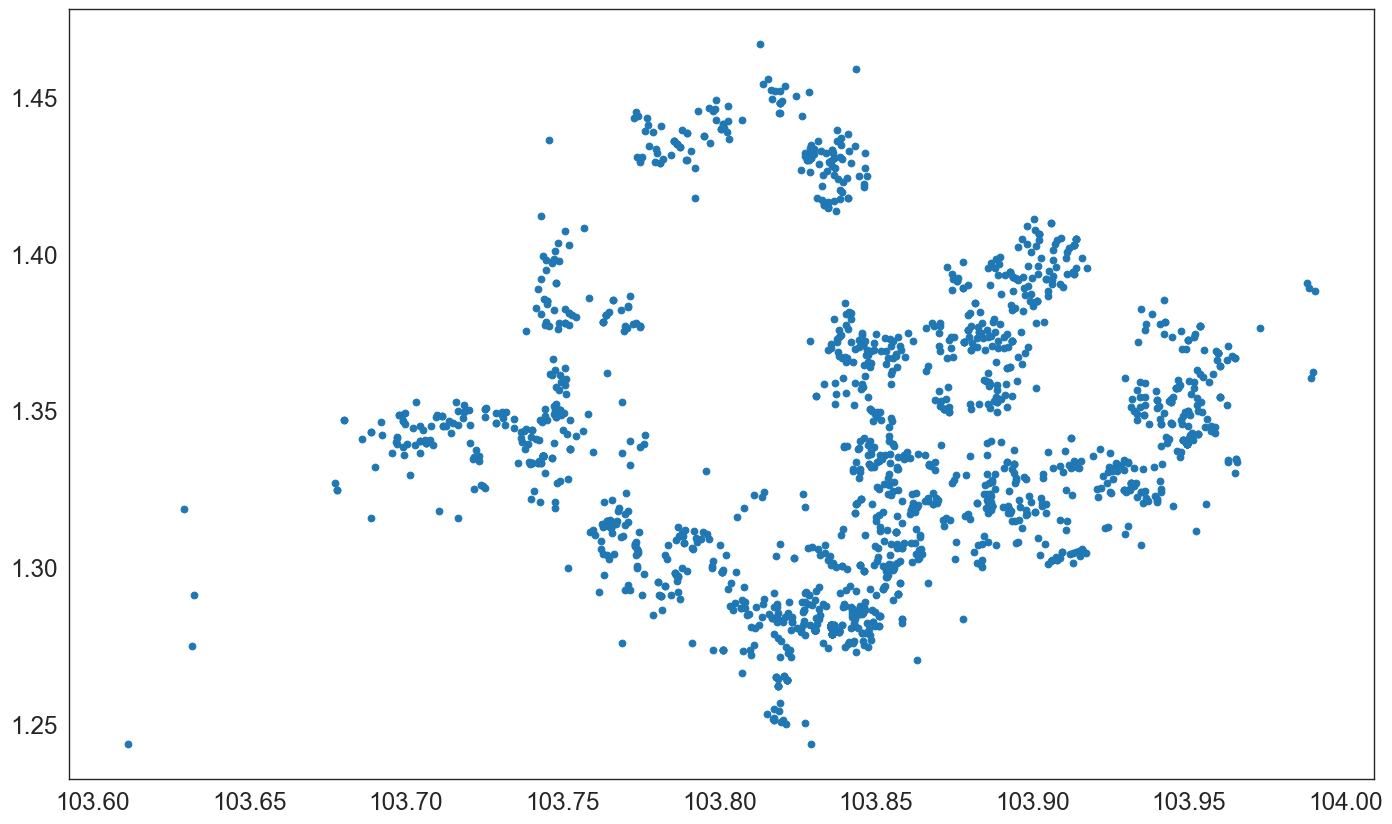

In [105]:
df.plot(figsize=(20, 10))

In [106]:
# https://beta.data.gov.sg/datasets/d_29f066d67df3eae91df8a42f443863c8/view
filepath = "../data/raw/NationalMapPolygonKML.geojson"
sg = gpd.read_file(filepath)

In [107]:
sg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         619 non-null    object  
 1   Description  619 non-null    object  
 2   geometry     619 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 14.6+ KB


In [108]:
# extract lat, lon from geometry
df["lat"] = df["geometry"].apply(lambda p: p.y)
df["lon"] = df["geometry"].apply(lambda p: p.x)

In [109]:
df.iloc[0]["Description"]

'<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>Y</th> <td>36922.92412</td> </tr><tr bgcolor=""> <th>X</th> <td>18450.95232</td> </tr><tr bgcolor="#E3E3F3"> <th>LOCATION_NAME</th> <td>Bukit Batok CC</td> </tr><tr bgcolor=""> <th>LOCATION_TYPE</th> <td>Community</td> </tr><tr bgcolor="#E3E3F3"> <th>POSTAL_CODE</th> <td>659959</td> </tr><tr bgcolor=""> <th>STREET_ADDRESS</th> <td>21 Bukit Batok Central</td> </tr><tr bgcolor="#E3E3F3"> <th>OPERATOR_NAME</th> <td>M1</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>9BB55356462956EF</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20200318162531</td> </tr></table></center>'

In [110]:
%%html
<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>Y</th> <td>36922.92412</td> </tr><tr bgcolor=""> <th>X</th> <td>18450.95232</td> </tr><tr bgcolor="#E3E3F3"> <th>LOCATION_NAME</th> <td>Bukit Batok CC</td> </tr><tr bgcolor=""> <th>LOCATION_TYPE</th> <td>Community</td> </tr><tr bgcolor="#E3E3F3"> <th>POSTAL_CODE</th> <td>659959</td> </tr><tr bgcolor=""> <th>STREET_ADDRESS</th> <td>21 Bukit Batok Central</td> </tr><tr bgcolor="#E3E3F3"> <th>OPERATOR_NAME</th> <td>M1</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>9BB55356462956EF</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20200318162531</td> </tr></table></center>

In [111]:
pd.read_html(df.iloc[0]["Description"])[0]

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/2504409835.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(df.iloc[0]["Description"])[0]


,Attributes,Attributes.1
0,Y,36922.92412
1,X,18450.95232
2,LOCATION_NAME,Bukit Batok CC
3,LOCATION_TYPE,Community
4,POSTAL_CODE,659959
5,STREET_ADDRESS,21 Bukit Batok Central
6,OPERATOR_NAME,M1
7,INC_CRC,9BB55356462956EF
8,FMEL_UPD_D,20200318162531


In [112]:
cols = pd.read_html(df.iloc[0]["Description"])[0]["Attributes"].apply(str.lower)
df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  cols = pd.read_html(df.iloc[0]["Description"])[0]["Attributes"].apply(str.lower)
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/var/folders/gm/ppd2vnjn0c1b0dkm71t7rz0m0000gn/T/ipykernel_96750/258152490.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df[cols] = df["Description"].apply(lambda s: pd.read_html(s)[0]["Attributes.1"])
/

In [113]:
df.head()
# some location_name are similar to street_address

,Name,Description,geometry,lat,lon,y,x,location_name,location_type,postal_code,street_address,operator_name,inc_crc,fmel_upd_d
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000),1.350191,103.747514,36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000),1.428036,103.836092,45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000),1.300197,103.852975,31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000),1.286329,103.846479,29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000),1.399229,103.889654,42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531


In [114]:
df.describe()
# 2 addresses are null
# some geometry/x/y are repeated
# some location_names/addresses are repeated
# 13 unique location types
# 4 unique operators
# inc_crc all unique (no pattern) -- ignore
# fmel_upd_d all the same (no variation) -- ignore

,lat,lon
count,1800.000000,1800.000000
mean,1.336579,103.840350
std,0.045960,0.065135
min,1.243470,103.611319
25%,1.298701,103.801261
50%,1.334516,103.839360
75%,1.367616,103.886950
max,1.466954,103.990314


In [115]:
df[df["street_address"].isnull()]

,Name,Description,geometry,lat,lon,y,x,location_name,location_type,postal_code,street_address,operator_name,inc_crc,fmel_upd_d
603,kml_604,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.92685 1.33336 0.00000),1.333358,103.926849,35061.66598,38409.87145,Kaki Bukit CC,Community,469627,NaN,M1,4FC2FCFFFBD9FAF2,20200318162531
1025,kml_1026,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.90966 1.38949 0.00000),1.389491,103.909660,41268.56347,36495.85597,Rivervale Arc RC,Community,543180,NaN,M1,9926559F2A4B5F8A,20200318162531


In [116]:
s = df.groupby("location_name")["inc_crc"].nunique()
s = s[s > 1]
print(len(s))
s.sort_values(ascending=False)
# just to see the repeated location names 

21


location_name
Housing and Development Board                        17
Sentosa Development Corporation                       7
Singapore Association of the Visually Handicapped     3
Bedok Integrated Complex                              2
National Kidney Foundation (NKF) - Tampines           2
Tampines Palmsville RC (Cafe Corner)                  2
Tampines Changkat Zone RC (Cafe Corner)               2
Siglap South CC                                       2
SUN-DAC@Bedok                                         2
Philip Securities Pte Ltd                             2
Performance Motors Limited                            2
Mountbatten CC                                        2
Chua Chu Kang Zone 6 RC                               2
McDonald's Bedok Reservoir                            2
KFC Management Pte Ltd                                2
Housing and Development Board (sin176)                2
Hong Kah North Zone 3 RC                              2
Food Courts / Canteen             

In [117]:
df["location_type"].value_counts()

location_type
Community                  557
F&B                        428
Healthcare                 415
Commercial                 125
Welfare Organisation       123
Public Transport            46
Government                  25
School                      24
Retail Shop                 23
Shopping Mall               16
Tourist Attraction          12
Dormitory / Care Centre      4
Public Worship               2
Name: count, dtype: int64

In [169]:
df[df["location_type"] == "Community"]["location_name"]
# location_name is a key feature!

0                               Bukit Batok CC
1                           1 Northpoint Drive
3                        20 Upper Pickering St
6                             ACE The Place CC
14                                   Acacia RC
                         ...                  
1412                  Tampines North Zone 6 RC
1413                  Tampines North Zone 7 RC
1578                               Keppel Club
1733    PASIR RIS ZONE '7' RESIDENTS COMMITTEE
1740                      People's Association
Name: location_name, Length: 557, dtype: object

In [119]:
df["operator_name"].value_counts()

operator_name
M1            1340
Singtel        355
MyRepublic      65
StarHub         40
Name: count, dtype: int64

In [151]:
pivot = df.pivot_table(values="x", index="operator_name", columns="location_type", aggfunc="count").fillna(0)
pivot
# there is a strong pattern between operator and location type
# e.g. 
# m1 do more community
# starhub do more schools
# myrepublic do more commercial

location_type,Commercial,Community,F&B,Government,Healthcare,Others,Public Transport,Retail Shop,School,Shopping Mall,Welfare Organisation
operator_name,,,,,,,,,,,
M1,45.0,554.0,198.0,15.0,360.0,18.0,2.0,17.0,2.0,7.0,122.0
MyRepublic,63.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Singtel,13.0,2.0,228.0,8.0,55.0,0.0,44.0,5.0,0.0,0.0,0.0
StarHub,4.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,22.0,9.0,1.0


<Axes: xlabel='location_type', ylabel='operator_name'>

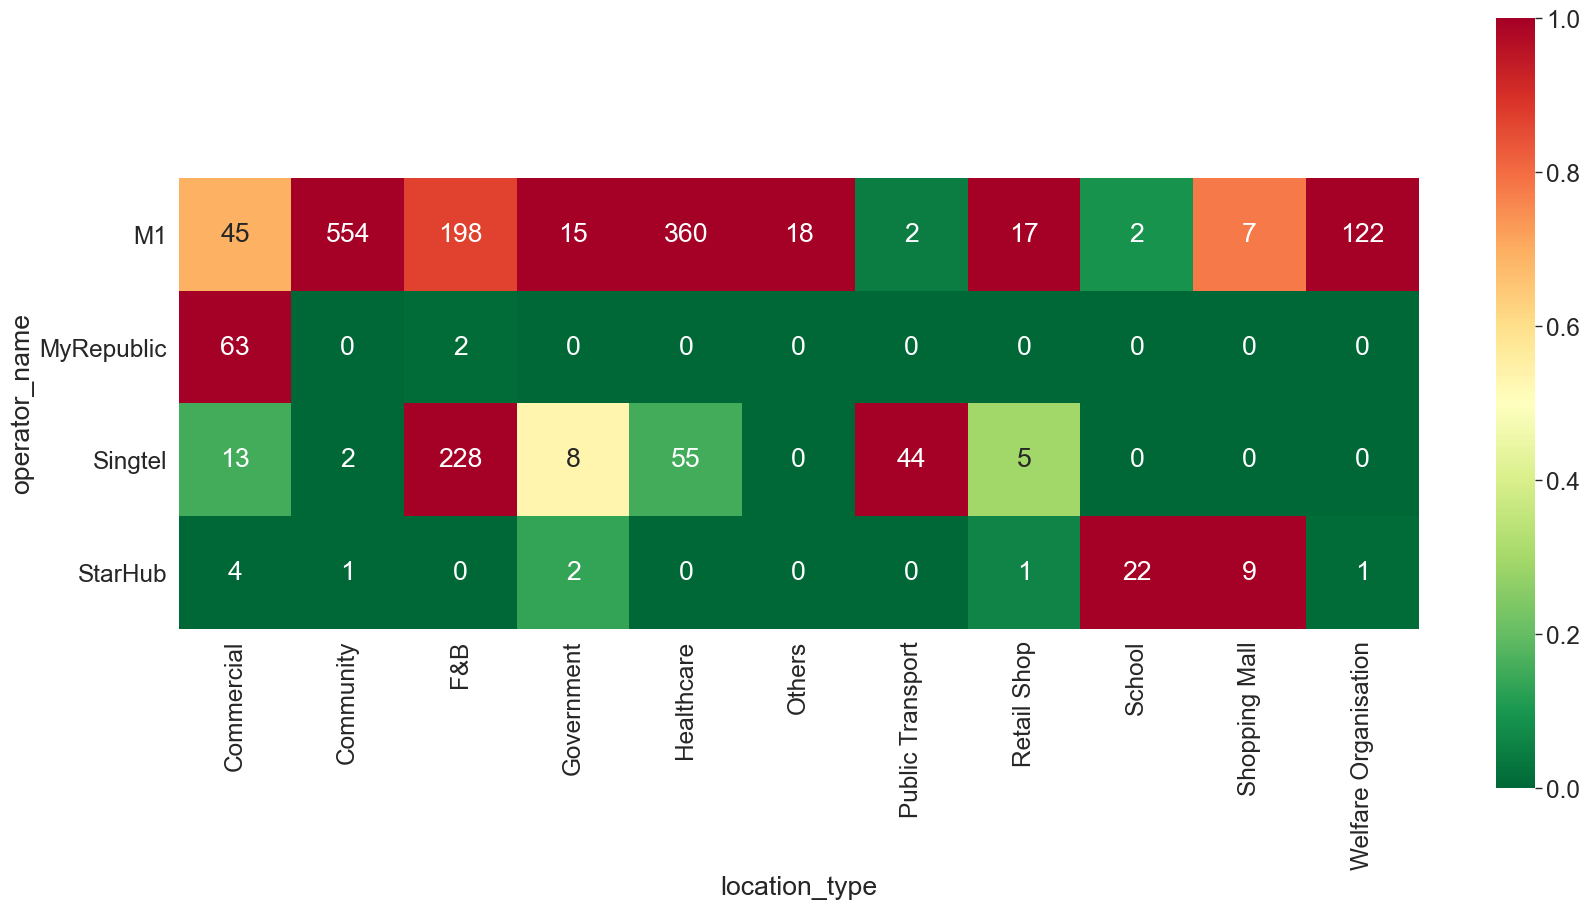

In [160]:
fig, ax = plt.subplots(figsize=(20,10))
scaled_pivot = (pivot - pivot.min(axis=0))/(pivot.max(axis=0) - pivot.min(axis=0))
sns.heatmap(scaled_pivot, annot=pivot, fmt="g", square=True, cmap="RdYlGn_r", ax=ax)

<Axes: >

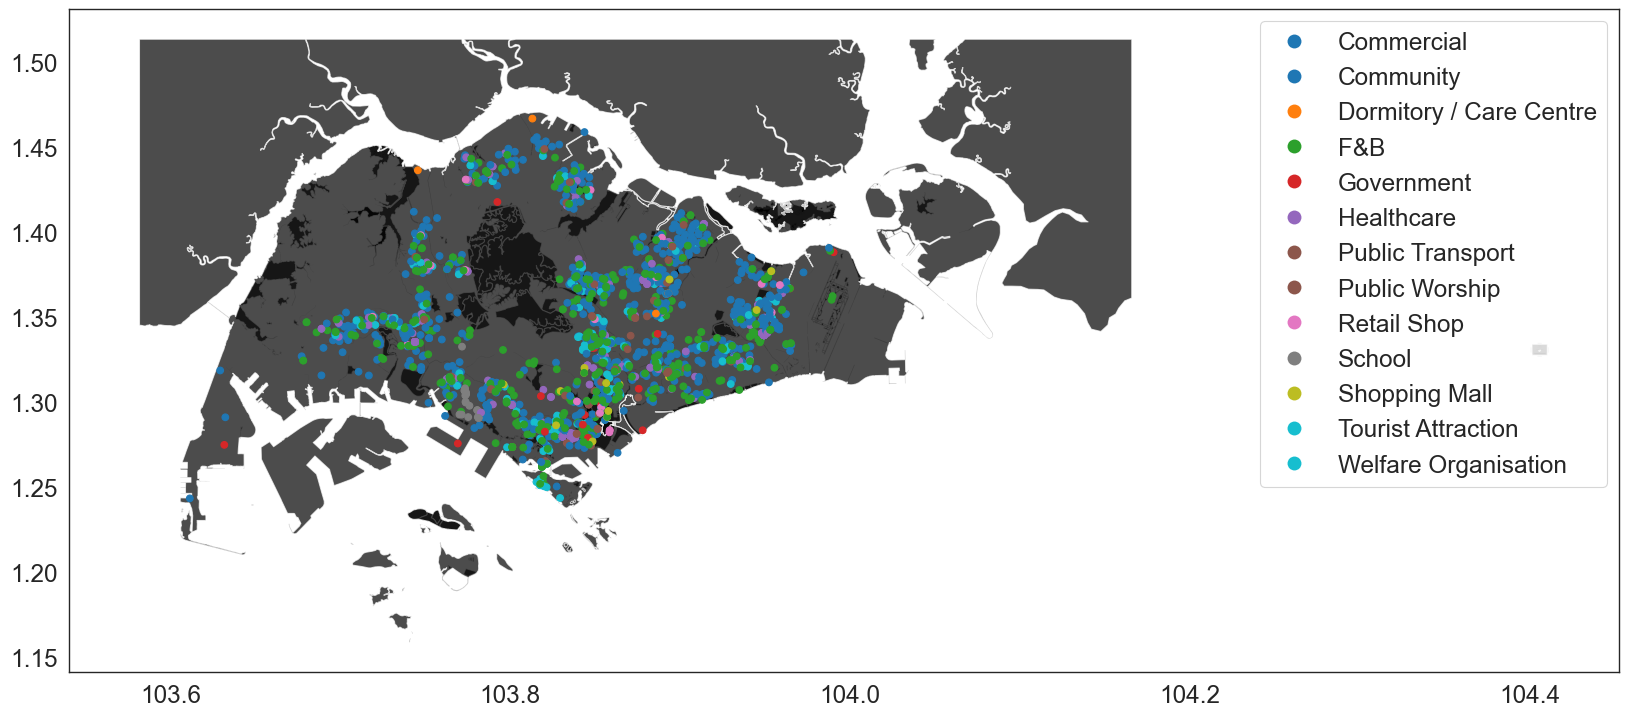

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
sg.plot(ax=ax, alpha=0.7, color="black")
df.plot("location_type", ax=ax, legend=True)

**Task 2**: Due to a system error, the location type column for the last 200 rows of the dataset has become garbled. Using all earlier rows as well as all other columns in the dataset, build a classification model to predict the location type for these hotspots. You may treat the three rarest location types as one category.
*(Note: you may wish to create some additional features based on available ones.)*

Models to consider:

Binary Transformation approach:
- One vs. One
- One vs. Rest

Native multi-class classifiers
- Naive Bayes
- Decision Trees
- k-Nearest Neighbours
- Ensemble models e.g. random forest
- Neural networks

## Prepare dataset

### Label

In [123]:
# questions says we may treat the 3 rarest location types as one category
df["location_type"].value_counts().sort_values()[:3]

location_type
Public Worship              2
Dormitory / Care Centre     4
Tourist Attraction         12
Name: count, dtype: int64

In [124]:
# rename 3 rarest location types to "others"
cols = list(df["location_type"].value_counts().sort_values()[:3].index)
for c in cols:
    df["location_type"] = df["location_type"].mask(df["location_type"] == c, "Others")

In [125]:
df["location_type"].value_counts()

location_type
Community               557
F&B                     428
Healthcare              415
Commercial              125
Welfare Organisation    123
Public Transport         46
Government               25
School                   24
Retail Shop              23
Others                   18
Shopping Mall            16
Name: count, dtype: int64

### Split dataset

In [126]:
cols = ["location_name", "lat", "lon", "operator_name", "location_type"]
dataset = df[cols]

In [127]:
# create one-hot encoding for categorical column
dataset = dataset.join(pd.get_dummies(dataset["operator_name"])).drop("operator_name", axis=1)

In [128]:
# shuffle the dataset
dataset = dataset.sample(frac=1, random_state=RANDOM_SEED)

In [178]:
filepath = "../data/processed/WirelessHotspots.csv"
dataset.to_csv(filepath)

In [129]:
train, test = dataset.iloc[:-200].reset_index(drop=True), dataset.iloc[-200:].reset_index(drop=True)
X_train, y_train = train.drop("location_type", axis=1), train["location_type"]
X_test, y_test = test.drop("location_type", axis=1), test["location_type"]

### Feature engineering

In [130]:
# handle location_name feature
keywords = [
    "rc", "cc", "rn", "zone", "nlb", "residents", "committee", "cafe", "hawker",  # community
    "kfc", "mcdonald", "pizza", "food", "coffee", "market", "makan",  "hotel", # f&b
    "nel", "mrt", "ccl", "ewl", "nsl", "bus",   # public transport
    "pte", "ltd", "limited", "group", "branch", "company", "industrial", "tower", "holding", # commercial
    "housing", "development", "board", "hdb", "ministiry", "national", "hub", "singapore", # government
    "hospital", "singhealth", "nfk", "sgh", "polyclinic", "medicine", "academia",
    "heart", "eye", "dental", "care",  # healthcare
    "boutique", "orchard",  # retail
    "hall", "canteen", "polytechnic", "school",  # school
    "mall", "plaza", "shopping", "square",  # shopping mall
    "home", "children", "outreach", "fsc", "sac", "senior", "seniors", "activity",   # welfare 
]
vocabulary = {keywords[i]: i for i in range(len(keywords))}
vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary)

X_train = X_train.join(pd.DataFrame(data=vectorizer.fit_transform(X_train["location_name"]).toarray(),
                                    columns=vectorizer.get_feature_names_out()))
X_test = X_test.join(pd.DataFrame(data=vectorizer.transform(X_test["location_name"]).toarray(),
                                    columns=vectorizer.get_feature_names_out()))

X_train = X_train.drop("location_name", axis=1)
X_test = X_test.drop("location_name", axis=1)

vectorizer.get_feature_names_out()

array(['rc', 'cc', 'rn', 'zone', 'nlb', 'residents', 'committee', 'cafe',
       'hawker', 'kfc', 'mcdonald', 'pizza', 'food', 'coffee', 'market',
       'makan', 'hotel', 'nel', 'mrt', 'ccl', 'ewl', 'nsl', 'bus', 'pte',
       'ltd', 'limited', 'group', 'branch', 'company', 'industrial',
       'tower', 'holding', 'housing', 'development', 'board', 'hdb',
       'ministiry', 'national', 'hub', 'singapore', 'hospital',
       'singhealth', 'nfk', 'sgh', 'polyclinic', 'medicine', 'academia',
       'heart', 'eye', 'dental', 'care', 'boutique', 'orchard', 'hall',
       'canteen', 'polytechnic', 'school', 'mall', 'plaza', 'shopping',
       'square', 'home', 'children', 'outreach', 'fsc', 'sac', 'senior',
       'seniors', 'activity'], dtype=object)

In [131]:
# handle numerical features
scaler = MinMaxScaler()
X_train[["lat", "lon"]] = pd.DataFrame(scaler.fit_transform(X_train[["lat", "lon"]]))
X_test[["lat", "lon"]] = pd.DataFrame(scaler.transform(X_test[["lat", "lon"]]))

In [132]:
X_train

,lat,lon,M1,MyRepublic,Singtel,StarHub,rc,cc,rn,zone,...,shopping,square,home,children,outreach,fsc,sac,senior,seniors,activity
0,0.435851,0.877035,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.170930,0.591740,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.411947,0.349732,False,False,True,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.034626,0.544112,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.134340,0.523558,True,False,False,False,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.577131,0.892880,False,False,True,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1596,0.502634,0.604829,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1597,0.373182,0.824627,True,False,False,False,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1598,0.398533,0.674727,True,False,False,False,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
X_test

,lat,lon,M1,MyRepublic,Singtel,StarHub,rc,cc,rn,zone,...,shopping,square,home,children,outreach,fsc,sac,senior,seniors,activity
0,0.338022,0.722569,True,False,False,False,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.897260,0.567220,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.192938,0.582149,True,False,False,False,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.562243,0.634038,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.256970,0.643606,False,False,True,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.511725,0.884994,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0.399694,0.792872,True,False,False,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
197,0.509387,0.882678,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0.540432,0.920102,True,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train model

In [182]:
def train_model(model_func):
    model = model_func().fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    filepath = f"../models/WirelessHotspot_{model_func}"
    joblib.dump(model, filepath) 
    print(f"Model: {model_func}, Train Accuracy: {accuracy_score(y_train_pred, y_train)}, Test Accuracy: {accuracy_score(y_test_pred, y_test)}")

In [186]:
model_functions = [
    SVC, LogisticRegression, SGDClassifier,
    DecisionTreeClassifier,
    MultinomialNB, ComplementNB,
    KNeighborsClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
]
for f in model_functions:
    train_model(f)
# Gradient Boosting Classifier has the best performance

Model: <class 'sklearn.svm._classes.SVC'>, Train Accuracy: 0.916875, Test Accuracy: 0.91
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>, Train Accuracy: 0.913125, Test Accuracy: 0.905
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>, Train Accuracy: 0.931875, Test Accuracy: 0.92
Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, Train Accuracy: 0.999375, Test Accuracy: 0.895
Model: <class 'sklearn.naive_bayes.MultinomialNB'>, Train Accuracy: 0.88125, Test Accuracy: 0.895
Model: <class 'sklearn.naive_bayes.ComplementNB'>, Train Accuracy: 0.884375, Test Accuracy: 0.885
Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, Train Accuracy: 0.92875, Test Accuracy: 0.915
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>, Train Accuracy: 0.999375, Test Accuracy: 0.915
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, Train Accuracy: 0.576875, Test Accuracy: 0.555
Model: <class 'sklea

## Evaluate model

**Task 3**: The information has now been recovered from a backup copy of the file. Compared to the true location types, how good was your model? Be prepared to explain the metrics you use to evaluate your model.

In [136]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

          Commercial       0.79      0.73      0.76        15
           Community       0.99      0.97      0.98        68
                 F&B       0.96      0.98      0.97        52
          Government       0.00      0.00      0.00         3
          Healthcare       0.86      1.00      0.92        37
              Others       0.00      0.00      0.00         0
    Public Transport       1.00      1.00      1.00         4
         Retail Shop       0.50      0.50      0.50         4
              School       1.00      1.00      1.00         2
       Shopping Mall       0.50      0.50      0.50         2
Welfare Organisation       0.90      0.69      0.78        13

            accuracy                           0.92       200
           macro avg       0.68      0.67      0.67       200
        weighted avg       0.91      0.92      0.91       200



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [137]:
# Look at incorrect samples
test["pred"] = y_pred
test[y_pred != y_test]

# improve keywords?

,location_name,lat,lon,location_type,M1,MyRepublic,Singtel,StarHub,pred
67,Family Services @ Teck Ghee,1.367890,103.847599,Welfare Organisation,True,False,False,False,Healthcare
78,Xin Cheng Construction,1.327992,103.875062,Commercial,True,False,False,False,Healthcare
81,Marina South Pier Ferry Terminal,1.270291,103.863149,Commercial,False,False,False,True,Shopping Mall
92,Silver ACE @ Taman Jurong,1.335581,103.723318,Community,True,False,False,False,Healthcare
95,Lakeside Family Centre (Jurong West),1.345504,103.720558,Welfare Organisation,True,False,False,False,Healthcare
101,SPD@Tampines,1.354251,103.934477,Welfare Organisation,True,False,False,False,Healthcare
111,THK SAC @ Kaki Bukit,1.333693,103.930397,Community,True,False,False,False,Welfare Organisation
124,Oasis Terrace,1.402878,103.913196,Government,True,False,False,False,Healthcare
132,Snipe Avenue Holdings Pte Ltd @ JURONG WEST ST 51,1.350384,103.719026,Retail Shop,True,False,False,False,Commercial
138,LTA-APO,1.274962,103.631630,Government,False,False,True,False,F&B


In [138]:
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=75, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(11, activation="softmax")
])

In [139]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [140]:
y_train_enc = pd.get_dummies(y_train)
y_train_enc

,Commercial,Community,F&B,Government,Healthcare,Others,Public Transport,Retail Shop,School,Shopping Mall,Welfare Organisation
0,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1595,False,False,True,False,False,False,False,False,False,False,False
1596,False,False,False,False,False,False,False,False,False,False,True
1597,False,True,False,False,False,False,False,False,False,False,False
1598,False,True,False,False,False,False,False,False,False,False,False


In [141]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [142]:
history = model.fit(X_train, y_train_enc, epochs=500, validation_split=0.1)

Epoch 1/500
45/45 [==============================] - 0s 2ms/step - loss: 2.3151 - accuracy: 0.2632 - val_loss: 2.2646 - val_accuracy: 0.3063
Epoch 2/500
45/45 [==============================] - 0s 855us/step - loss: 2.1963 - accuracy: 0.3236 - val_loss: 2.1452 - val_accuracy: 0.2875
Epoch 3/500
45/45 [==============================] - 0s 757us/step - loss: 2.0607 - accuracy: 0.3215 - val_loss: 2.0287 - val_accuracy: 0.2875
Epoch 4/500
45/45 [==============================] - 0s 715us/step - loss: 1.9666 - accuracy: 0.3187 - val_loss: 1.9340 - val_accuracy: 0.2875
Epoch 5/500
45/45 [==============================] - 0s 705us/step - loss: 1.8732 - accuracy: 0.3187 - val_loss: 1.8532 - val_accuracy: 0.2875
Epoch 6/500
45/45 [==============================] - 0s 704us/step - loss: 1.7926 - accuracy: 0.3451 - val_loss: 1.7828 - val_accuracy: 0.2875
Epoch 7/500
45/45 [==============================] - 0s 709us/step - loss: 1.7282 - accuracy: 0.3535 - val_loss: 1.7193 - val_accuracy: 0.3313
E

Epoch 58/500
45/45 [==============================] - 0s 704us/step - loss: 0.6932 - accuracy: 0.7736 - val_loss: 0.6789 - val_accuracy: 0.7812
Epoch 59/500
45/45 [==============================] - 0s 741us/step - loss: 0.6889 - accuracy: 0.7826 - val_loss: 0.6720 - val_accuracy: 0.7750
Epoch 60/500
45/45 [==============================] - 0s 757us/step - loss: 0.6923 - accuracy: 0.7833 - val_loss: 0.6728 - val_accuracy: 0.7812
Epoch 61/500
45/45 [==============================] - 0s 783us/step - loss: 0.6988 - accuracy: 0.7646 - val_loss: 0.6703 - val_accuracy: 0.7750
Epoch 62/500
45/45 [==============================] - 0s 734us/step - loss: 0.6849 - accuracy: 0.7819 - val_loss: 0.6645 - val_accuracy: 0.7812
Epoch 63/500
45/45 [==============================] - 0s 699us/step - loss: 0.6718 - accuracy: 0.7799 - val_loss: 0.6593 - val_accuracy: 0.7812
Epoch 64/500
45/45 [==============================] - 0s 687us/step - loss: 0.6776 - accuracy: 0.7840 - val_loss: 0.6554 - val_accuracy:

Epoch 115/500
45/45 [==============================] - 0s 690us/step - loss: 0.5705 - accuracy: 0.8021 - val_loss: 0.5883 - val_accuracy: 0.7500
Epoch 116/500
45/45 [==============================] - 0s 693us/step - loss: 0.5665 - accuracy: 0.8014 - val_loss: 0.5867 - val_accuracy: 0.7500
Epoch 117/500
45/45 [==============================] - 0s 981us/step - loss: 0.5630 - accuracy: 0.7972 - val_loss: 0.5826 - val_accuracy: 0.7437
Epoch 118/500
45/45 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.8056 - val_loss: 0.5821 - val_accuracy: 0.7437
Epoch 119/500
45/45 [==============================] - 0s 1ms/step - loss: 0.5762 - accuracy: 0.7854 - val_loss: 0.5817 - val_accuracy: 0.7375
Epoch 120/500
45/45 [==============================] - 0s 917us/step - loss: 0.5625 - accuracy: 0.8021 - val_loss: 0.5789 - val_accuracy: 0.7500
Epoch 121/500
45/45 [==============================] - 0s 1ms/step - loss: 0.5483 - accuracy: 0.8007 - val_loss: 0.5783 - val_accuracy

Epoch 172/500
45/45 [==============================] - 0s 823us/step - loss: 0.5260 - accuracy: 0.8069 - val_loss: 0.5228 - val_accuracy: 0.8375
Epoch 173/500
45/45 [==============================] - 0s 798us/step - loss: 0.5207 - accuracy: 0.8208 - val_loss: 0.5209 - val_accuracy: 0.8438
Epoch 174/500
45/45 [==============================] - 0s 835us/step - loss: 0.5086 - accuracy: 0.8181 - val_loss: 0.5173 - val_accuracy: 0.8375
Epoch 175/500
45/45 [==============================] - 0s 764us/step - loss: 0.5090 - accuracy: 0.8194 - val_loss: 0.5156 - val_accuracy: 0.8438
Epoch 176/500
45/45 [==============================] - 0s 745us/step - loss: 0.5198 - accuracy: 0.8174 - val_loss: 0.5192 - val_accuracy: 0.8438
Epoch 177/500
45/45 [==============================] - 0s 723us/step - loss: 0.5065 - accuracy: 0.8208 - val_loss: 0.5123 - val_accuracy: 0.8375
Epoch 178/500
45/45 [==============================] - 0s 735us/step - loss: 0.5158 - accuracy: 0.8125 - val_loss: 0.5131 - val_ac

45/45 [==============================] - 0s 703us/step - loss: 0.4312 - accuracy: 0.8500 - val_loss: 0.4213 - val_accuracy: 0.8687
Epoch 285/500
45/45 [==============================] - 0s 693us/step - loss: 0.4414 - accuracy: 0.8562 - val_loss: 0.4160 - val_accuracy: 0.8750
Epoch 286/500
45/45 [==============================] - 0s 708us/step - loss: 0.4480 - accuracy: 0.8493 - val_loss: 0.4265 - val_accuracy: 0.8687
Epoch 287/500
45/45 [==============================] - 0s 757us/step - loss: 0.4407 - accuracy: 0.8514 - val_loss: 0.4204 - val_accuracy: 0.8687
Epoch 288/500
45/45 [==============================] - 0s 783us/step - loss: 0.4320 - accuracy: 0.8507 - val_loss: 0.4188 - val_accuracy: 0.8750
Epoch 289/500
45/45 [==============================] - 0s 808us/step - loss: 0.4244 - accuracy: 0.8576 - val_loss: 0.4198 - val_accuracy: 0.8750
Epoch 290/500
45/45 [==============================] - 0s 723us/step - loss: 0.4247 - accuracy: 0.8556 - val_loss: 0.4126 - val_accuracy: 0.8687

45/45 [==============================] - 0s 692us/step - loss: 0.4145 - accuracy: 0.8500 - val_loss: 0.3790 - val_accuracy: 0.8687
Epoch 397/500
45/45 [==============================] - 0s 692us/step - loss: 0.4044 - accuracy: 0.8569 - val_loss: 0.3741 - val_accuracy: 0.8687
Epoch 398/500
45/45 [==============================] - 0s 751us/step - loss: 0.3929 - accuracy: 0.8590 - val_loss: 0.3934 - val_accuracy: 0.8687
Epoch 399/500
45/45 [==============================] - 0s 778us/step - loss: 0.3805 - accuracy: 0.8625 - val_loss: 0.3816 - val_accuracy: 0.8687
Epoch 400/500
45/45 [==============================] - 0s 802us/step - loss: 0.3931 - accuracy: 0.8660 - val_loss: 0.3889 - val_accuracy: 0.8687
Epoch 401/500
45/45 [==============================] - 0s 735us/step - loss: 0.3908 - accuracy: 0.8653 - val_loss: 0.3779 - val_accuracy: 0.8687
Epoch 402/500
45/45 [==============================] - 0s 696us/step - loss: 0.3910 - accuracy: 0.8660 - val_loss: 0.3801 - val_accuracy: 0.8687

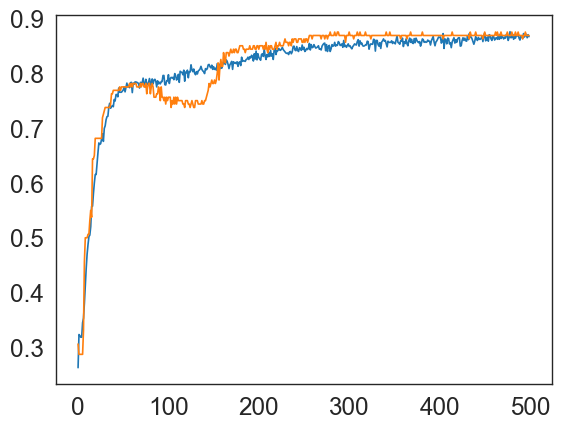

In [143]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

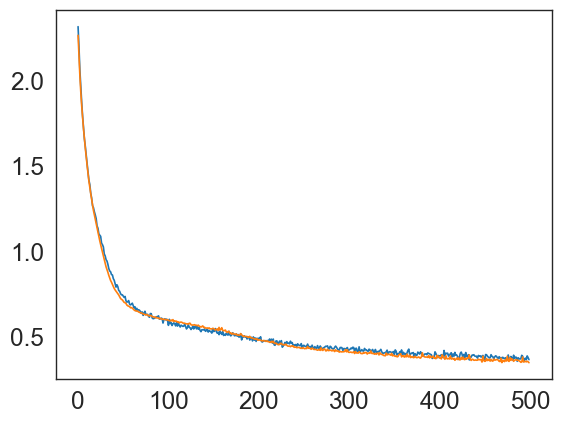

In [144]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [172]:
y_train_pred = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=-1)

50/50 [==============================] - 0s 334us/step


In [173]:
y_train_pred = [y_train_enc.columns[x] for x in y_train_pred]

In [174]:
print(classification_report(y_train, y_train_pred))

                      precision    recall  f1-score   support

          Commercial       0.77      0.75      0.76       110
           Community       1.00      0.96      0.98       489
                 F&B       0.96      0.98      0.97       376
          Government       0.00      0.00      0.00        22
          Healthcare       0.88      0.98      0.93       378
              Others       0.00      0.00      0.00        18
    Public Transport       1.00      1.00      1.00        42
         Retail Shop       0.00      0.00      0.00        19
              School       0.00      0.00      0.00        22
       Shopping Mall       1.00      0.14      0.25        14
Welfare Organisation       0.56      0.87      0.68       110

            accuracy                           0.90      1600
           macro avg       0.56      0.52      0.51      1600
        weighted avg       0.87      0.90      0.87      1600



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [145]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

7/7 [==============================] - 0s 653us/step


In [146]:
y_pred = [y_train_enc.columns[x] for x in y_pred]

In [147]:
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

          Commercial       0.68      0.87      0.76        15
           Community       1.00      0.97      0.99        68
                 F&B       0.96      0.98      0.97        52
          Government       0.00      0.00      0.00         3
          Healthcare       0.86      0.97      0.91        37
    Public Transport       1.00      1.00      1.00         4
         Retail Shop       0.00      0.00      0.00         4
              School       0.00      0.00      0.00         2
       Shopping Mall       1.00      0.50      0.67         2
Welfare Organisation       0.67      0.77      0.71        13

            accuracy                           0.91       200
           macro avg       0.62      0.61      0.60       200
        weighted avg       0.87      0.91      0.89       200



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta